## Connect and List Entries

Connect to your ReductStore instance and list the entries in a bucket.

In [10]:
import pandas as pd
from reduct import Client

REDUCT_URL = "http://orion.field.demo/"
API_TOKEN = "demo"
BUCKET = "orion"

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    entries = await bucket.get_entry_list()
    df = (
        pd.DataFrame([{"entry": e.name} for e in entries])
        .sort_values("entry")
        .reset_index(drop=True)
    )

df.head()

,entry
0,camera_info
1,image
2,imu
3,magnetic_field
4,point_cloud


## Extract Tabular Data from JSON

Select IMU columns and filter rows where `linear_acceleration_z < -5`.

In [ ]:
import json
import pandas as pd
from reduct import Client

JSON_ENTRY = "imu"

ext = {
    "select": {
        "json": {},
        "columns": [
            {"name": "ts_ns"},
            {"name": "linear_acceleration_x"},
            {"name": "linear_acceleration_y"},
            {"name": "linear_acceleration_z", "as_label": "acc_z"},
        ],
    },
    # "when": {"@acc_z": {"$lt": -5}},
}

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    parts = []
    async for rec in bucket.query(JSON_ENTRY, ext=ext):
        blob = await rec.read_all()
        rows = json.loads(blob.decode("utf-8"))
        parts.append(pd.DataFrame(rows))
    df_json = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

df_json.head()

## Extract from MCAP

Extract `/vectornav/IMU_restamped` messages directly from `mcap` files and load them into a DataFrame.

In [ ]:
import json
import pandas as pd
from reduct import Client

MCAP_ENTRY = "mcap"
IMU_TOPIC = "/vectornav/IMU_restamped"

ext = {
    "ros": {"extract": {"topic": IMU_TOPIC}},
}

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    parts = []
    async for rec in bucket.query(MCAP_ENTRY, ext=ext):
        blob = await rec.read_all()
        data = json.loads(blob.decode("utf-8"))
        rows = [
            {
                "ts_ns": data["header"]["stamp"]["sec"] * 1_000_000_000
                + data["header"]["stamp"]["nanosec"],
                "linear_acceleration_x": data["linear_acceleration"]["x"],
                "linear_acceleration_y": data["linear_acceleration"]["y"],
                "linear_acceleration_z": data["linear_acceleration"]["z"],
            }
        ]
        parts.append(pd.DataFrame(rows))

    df_ros = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

df_ros.head()

## Extract raw images

Read a few images and display them.

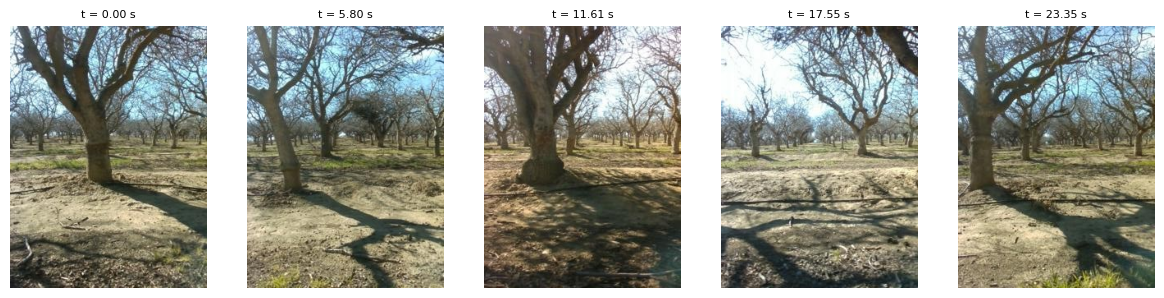

In [5]:
import io
from PIL import Image
import matplotlib.pyplot as plt
from reduct import Client

ENTRY = "image"
MAX_FRAMES = 5

imgs, timestamps, labels = [], [], []

when = {"$each_t": "5s", "$limit": MAX_FRAMES}

async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    async for rec in bucket.query(ENTRY, when=when):
        blob = await rec.read_all()
        imgs.append(Image.open(io.BytesIO(blob)))
        timestamps.append(rec.timestamp)
        labels.append(rec.labels)

t0 = timestamps[0] if timestamps else 0
rel_times = [(ts - t0) / 1e6 for ts in timestamps]

fig, axes = plt.subplots(1, len(imgs), figsize=(12, 3))

for ax, im, t, lbl in zip(axes, imgs, rel_times, labels):
    ax.imshow(im)
    ax.axis("off")
    ax.set_title(f"t = {t:.2f} s", fontsize=8)

plt.tight_layout()
plt.show()

## Extract raw PointCloud2

Read a few PointCloud2 frames and visualize them.

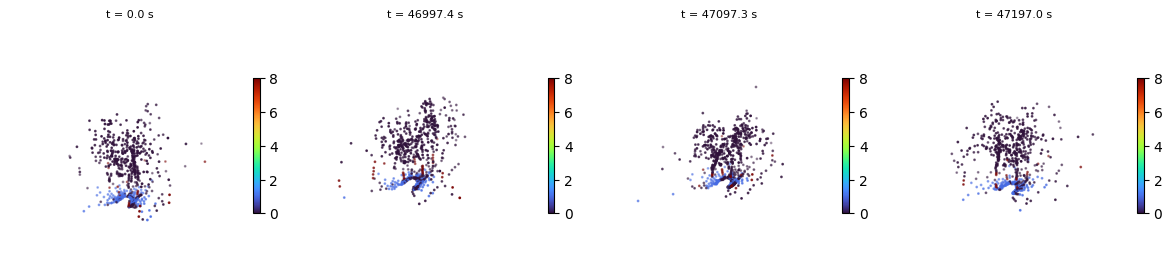

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from reduct import Client

ENTRY = "point_cloud"
MAX_SCANS = 4
when = {"$each_t": "5s", "$limit": MAX_SCANS}

scans, metas, stamps = [], [], []
async with Client(REDUCT_URL, api_token=API_TOKEN) as client:
    bucket = await client.get_bucket(BUCKET)
    async for rec in bucket.query(ENTRY, when=when):
        scans.append(await rec.read_all())
        metas.append(rec.labels)
        stamps.append(rec.timestamp)


def to_xyz(blob, meta):
    ps = int(meta["point_step"])
    dt = np.dtype(
        {
            "names": ["x", "y", "z", "intensity"],
            "formats": ["<f4", "<f4", "<f4", "<f4"],
            "offsets": [0, 4, 8, 12],
            "itemsize": ps,
        }
    )
    pc = np.frombuffer(blob, dtype=dt)
    return pc["x"], pc["y"], pc["z"], pc["intensity"]


t0 = stamps[0] if stamps else 0
rel_t = [(t - t0) / 1e6 for t in stamps]

fig = plt.figure(figsize=(12, 3))
for i, (blob, meta, t) in enumerate(zip(scans, metas, rel_t), 1):
    x, y, z, inten = to_xyz(blob, meta)
    s = 100  # take every 100th point
    ax = fig.add_subplot(1, len(scans), i, projection="3d")
    p = ax.scatter(x[::s], y[::s], z[::s], c=inten[::s], cmap="turbo", s=1)
    ax.set_title(f"t = {t:.1f} s", fontsize=8)
    ax.axis("off")
    fig.colorbar(p, ax=ax, shrink=0.5, pad=0.01)

plt.tight_layout()
plt.show()

## Vizualize in Foxglove

Create a sharable link to visualize the extracted data in Foxglove.

In [ ]:
# TODO: sharable link are available with v1.17.0